# Figura de merito de los criterios tradicionales

En este Notebook se calculan las figuras de merito de las los criterios Bonelo, Bolt y 


In [12]:
import  sys
import os 

dir_actual = os.path.abspath('')
dir_raiz = os.path.dirname(dir_actual)
# Añadir la ruta raíz al sys.path si aún no está
if dir_raiz not in sys.path:
    sys.path.append(dir_raiz)
print(f"Ruta raíz del proyecto añadida al path: {dir_raiz}")
from mesh.mesh_3D_generator import generate_mesh_parallelepiped
#Frecuencia maxima de simulacion
import numpy as np
from FEM.FEM_source import FEM_Source_Solver_Average
from mesh.mesh_3D_complex import create_complex_mesh

def calcular_area_poligono(vertices):

    """
    Calcula el área de un polígono irregular usando la Fórmula del Shoelace.

    Args:
        vertices (np.array): Un array de NumPy de forma (N, 2) con las coordenadas
                             [x, y] de los N vértices del polígono.

    Returns:
        float: El área del polígono.
    """
    # Se asegura de que los vértices sean un array de NumPy
    vertices = np.array(vertices)
    
    # Separa las coordenadas x e y
    x = vertices[:, 0]
    y = vertices[:, 1]
    
    # Aplica la fórmula del Shoelace de forma vectorizada
    # (x_i * y_{i+1}) - (y_i * x_{i+1})
    # np.roll(y, -1) desplaza circularmente el array 'y' para obtener los y_{i+1}
    area = 0.5 * np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))
    
    return area

def calcular_volumen(vertices, Lz):
    V = calcular_area_poligono(vertices) *Lz
    return V


f_max = 200
f_min = 20

#Dimensiones del Recinto base

Lz = 2.14
######## DIMENSIONES INICIALES MUYY CHICAS PARA PROBAR DEPUES CAMBIAR #############


              #x[m]        y[m]
sala_1 =   [[0.10416667  ,0.       ],
            [0.11       ,1.43      ],
            [0.22       ,2.09      ],
            [0.66       ,2.31      ],
            [0.83333333 ,3.        ],
            [1.66666667 ,3.        ],
            [1.84       ,2.31      ],
            [2.28       ,2.09      ],
            [2.39       ,1.43      ],
            [2.39583333 ,0.        ]]



source_position = (1.9, 1.0, 1.3)
receptor_position = (1.25, 1.9, 1.2)



Ruta raíz del proyecto añadida al path: /home/matias/Acoustic-Modal-Response-Optimizer


Cargamos los ratios conocidaos

In [13]:
base_cuadrada = np.array([  [0.0, 0.0],  
                            [1.0, 0.0],  
                            [1.0, 1.0],  
                            [0.0, 1.0] ])

def ajuste_de_volumen(ratio, V_target):
    base_cuadrada = np.array([  [0.0, 0.0],  
                                [1.0, 0.0],  
                                [1.0, 1.0],  
                                [0.0, 1.0] ])
    base = ratio[:2]
    base = base_cuadrada * base
    Lz = ratio[2]
    V = calcular_volumen(base, Lz)
    cte =  V_target / V
    base = base * (cte**(1/3))
    Lz = Lz * (cte**(1/3))
    return base, Lz 

Volumen = calcular_volumen(sala_1, Lz)
print("El volumen es ", Volumen,"m3")


Bolt     = np.array([3.52, 2.47, 2.2])
Louden   = np.array([4.18, 3.08, 2.2])
Cox      = np.array([4.07, 3.41, 2.2])

ratios = {
    'Bolt'  :np.array([3.52, 2.47, 2.2]),
    'Louden': np.array([4.18, 3.08, 2.2]),
    'Cox'   : np.array([4.07, 3.41, 2.2]),
}

dimensiones = { nombre: ajuste_de_volumen(ratio, Volumen)
               for nombre, ratio in ratios.items()}

# Nuestra sala 
sala_1 =   [[0.10416667  ,0.       ],
            [0.11       ,1.43      ],
            [0.22       ,2.09      ],
            [0.66       ,2.31      ],
            [0.83333333 ,3.        ],
            [1.66666667 ,3.        ],
            [1.84       ,2.31      ],
            [2.28       ,2.09      ],
            [2.39       ,1.43      ],
            [2.39583333 ,0.        ]]
Lz =2.25

dimensiones['Optimizado'] = (sala_1, Lz)


El volumen es  12.309155161388002 m3


In [14]:
import numpy as np
import matplotlib.pyplot as plt


from mesh.mesh_3D_complex import create_complex_mesh
from mesh.mesh_3D_simple import create_simple_mesh
from FEM.FEM_source import FEM_Source_Solver_Average
from aux.merit_figure import merit_magnitude_deviation, merit_spatial_deviation


def solve_complex_geom( Lz, source_position, receptor_position, room, res_freq=1):
  
    
    # Parametros de control
    f_max = 200

    mesh1 = "room_mesh_complex1"  # Crear malla con el script correspondiente
    mesh2 = "room_mesh_complex2"  # Crear malla con el script correspondiente
    mesh3 = "room_mesh_complex3"  # Crear malla con el script correspondiente
    print("Iniciando Generacion de mallas")
    create_complex_mesh(room, Lz, source_position, 80, mesh1)
    print("malla 1 generada")
    create_complex_mesh(room, Lz, source_position, 140, mesh2)
    print("malla 2 generada")
    create_complex_mesh(room, Lz, source_position, f_max, mesh3)
    print("mallas generadas")
    # Evalua la rta en frecuencia para esa sala
    f1 = np.arange(20, 80, res_freq)
    res1 = FEM_Source_Solver_Average(f1, f'mallado/{mesh1}.msh', receptor_position)

    f2 = np.arange(80, 140, res_freq)
    res2 = FEM_Source_Solver_Average(f2, f'mallado/{mesh2}.msh', receptor_position)

    f3 = np.arange(140, f_max, res_freq)
    res3 = FEM_Source_Solver_Average(f3, f'mallado/{mesh3}.msh', receptor_position)

    res_tot = np.hstack([res1, res2, res3])
    res_tot_prom = np.sum(res_tot, axis=0) / 7

    # Calcula figuras de mérito
    sv_merit = merit_spatial_deviation(res_tot)
    md_merit = merit_magnitude_deviation(res_tot)
    merit = (md_merit + sv_merit, md_merit, sv_merit)
    
    return merit, res_tot_prom

resultados = {}

# Itera sobre los nombres (claves) del diccionario 'dimensiones'
for criterio in dimensiones: 
    print("Calculando ", criterio)

    # Acceso CORRECTO a los datos usando corchetes []
    room, Lz = dimensiones[criterio]
    
    # Llama a tu función de simulación
    merit, response = solve_complex_geom(Lz, source_position, receptor_position, room, res_freq=.5)
    
    # 2. Añade el nuevo resultado al diccionario (en lugar de re-crearlo)
    resultados[criterio] = merit
    
# Al final del bucle, 'resultados' contendrá todas las entradas
print("\nDiccionario final de resultados:")
print(resultados)


Calculando  Bolt
Iniciando Generacion de mallas
malla 1 generada
malla 2 generada
mallas generadas
Info    : Reading 'mallado/room_mesh_complex1.msh'...
Info    : 33 entities
Info    : 512 nodes
Info    : 2735 elements
Info    : Done reading 'mallado/room_mesh_complex1.msh'
Info    : Reading 'mallado/room_mesh_complex2.msh'...
Info    : 33 entities
Info    : 1335 nodes
Info    : 7408 elements
Info    : Done reading 'mallado/room_mesh_complex2.msh'
Info    : Reading 'mallado/room_mesh_complex3.msh'...
Info    : 33 entities
Info    : 4720 nodes
Info    : 27684 elements
Info    : Done reading 'mallado/room_mesh_complex3.msh'
Calculando  Louden
Iniciando Generacion de mallas
malla 1 generada
malla 2 generada
mallas generadas
Info    : Reading 'mallado/room_mesh_complex1.msh'...
Info    : 33 entities
Info    : 458 nodes
Info    : 2429 elements
Info    : Done reading 'mallado/room_mesh_complex1.msh'
Info    : Reading 'mallado/room_mesh_complex2.msh'...
Info    : 33 entities
Info    : 1282 no

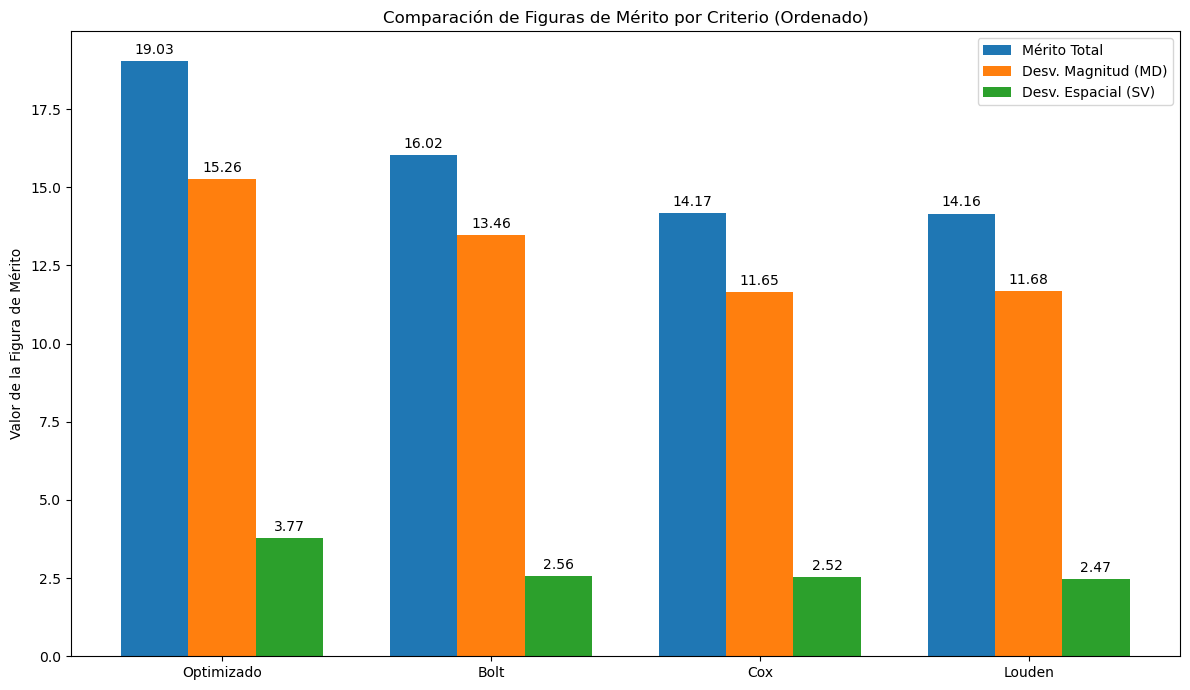

In [15]:

# valor de la tupla (el 'Mérito Total').
# - `key=lambda item: item[1][0]`: Le dice a sorted que mire el primer [0] elemento del valor [1] de cada item.
# - `reverse=True`: Especifica que el orden es descendente.
sorted_items = sorted(resultados.items(), key=lambda item: item[1][0], reverse=True)

# --- 2. Preparar los Datos Ordenados para el Gráfico ---

# Desempaqueta los resultados ya ordenados en listas separadas
nombres_ordenados = [item[0] for item in sorted_items]
valores_ordenados = [item[1] for item in sorted_items]

merito_total = [valor[0] for valor in valores_ordenados]
merito_md    = [valor[1] for valor in valores_ordenados]
merito_sv    = [valor[2] for valor in valores_ordenados]

# --- 3. Creación del Gráfico de Barras (sin cambios en la lógica) ---

# Configuración de posiciones en el eje X
x = np.arange(len(nombres_ordenados))
width = 0.25

# Creación de la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 7))

# Creación de las barras usando los datos ya ordenados
rects1 = ax.bar(x - width, merito_total, width, label='Mérito Total')
rects2 = ax.bar(x, merito_md, width, label='Desv. Magnitud (MD)')
rects3 = ax.bar(x + width, merito_sv, width, label='Desv. Espacial (SV)')

# --- 4. Añadir Etiquetas, Títulos y Leyenda ---

ax.set_ylabel('Valor de la Figura de Mérito')
ax.set_title('Comparación de Figuras de Mérito por Criterio (Ordenado)')
ax.set_xticks(x)
ax.set_xticklabels(nombres_ordenados) # Usa los nombres ya ordenados
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')

fig.tight_layout()
plt.show()

